In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import RocCurveDisplay,roc_curve,auc,recall_score
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import glob
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb.__version__

In [4]:
# node_df_pi=pd.read_parquet('../Data/preprocessed/raw/pi-_10GeV_4ly_2e-4/TrkData_viewx_cl_TB_2023_T10_Sept_pi-Mono_10000_onAxis_10000-evt-150_pitch0.25node_df.parquet')

In [3]:
%%time
folder_path = '../Data/preprocessed/raw/pi-_10GeV_4ly_1e-4/'
file_list = glob.glob(folder_path + 'TrkData_viewx_cl_TB_2023_T10_Sept_pi-Mono_10000_onAxis_10000-evt-1*_pitch0.25node_df.parquet')

CPU times: user 10.5 ms, sys: 8.53 ms, total: 19.1 ms
Wall time: 17 ms


In [4]:
%%time
file_list=file_list[:100]

node_df_pi = pd.DataFrame()

for file_path in file_list:
    df = pd.read_parquet(file_path)
    node_df_pi = pd.concat([node_df_pi, df], ignore_index=True)

CPU times: user 1.46 s, sys: 692 ms, total: 2.15 s
Wall time: 2.67 s


In [5]:
%%time
node_df_pi=node_df_pi.drop(columns=['Ev'])
node_df_pi=node_df_pi.drop(columns=['idx_node'])
node_df_pi=node_df_pi.drop(columns=['xMC'])

CPU times: user 121 ms, sys: 110 ms, total: 231 ms
Wall time: 229 ms


CPU times: user 64.8 ms, sys: 25.1 ms, total: 89.9 ms
Wall time: 60.9 ms


<Axes: >

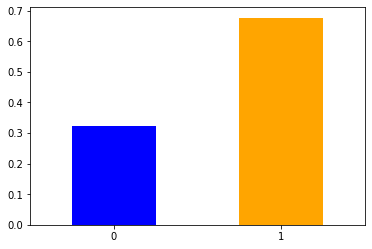

In [6]:
%%time
hit_count = node_df_pi['hit_class'].value_counts().sort_index()
hit_count/=len(node_df_pi)
hit_count.plot(kind='bar', rot=1, color=['blue', 'orange'])

In [7]:
%%time
import torch
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha':[0, 0.5, 1, 5],
    'reg_lambda':[0, 0.5, 1, 5]   
}
xgb_model = xgb.XGBClassifier(device = "cuda",tree_method="hist")
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy',refit=True)

X_train, X_test, y_train, y_test = train_test_split(node_df_pi.iloc[:,:-3], node_df_pi.iloc[:,-1], test_size=0.2, random_state=0)


CPU times: user 1.79 s, sys: 358 ms, total: 2.15 s
Wall time: 2.56 s


In [10]:
import pickle
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [105]:
y_pred = best_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.80%


In [106]:
y_pred_exp=best_model.predict(exp_df.iloc[:,1:])

In [107]:
exp_df['y_pred']=y_pred_exp

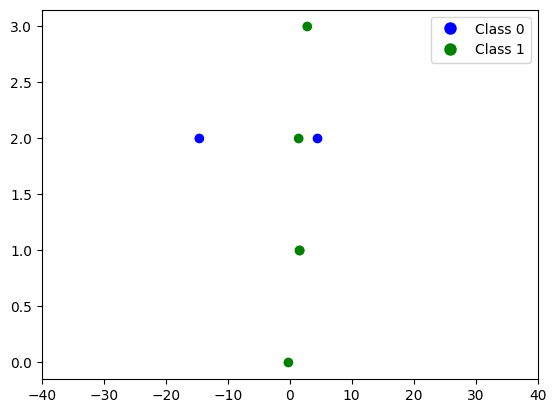

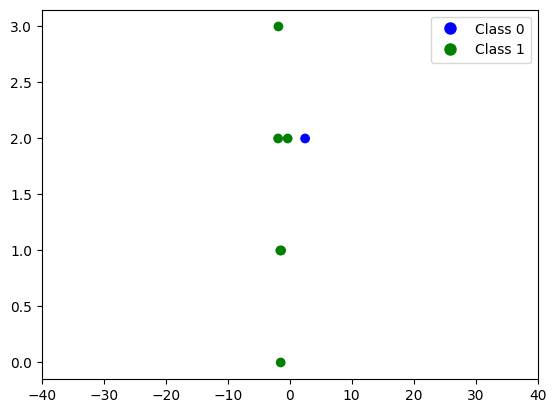

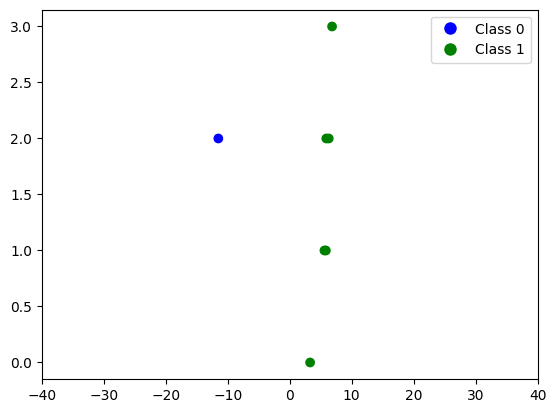

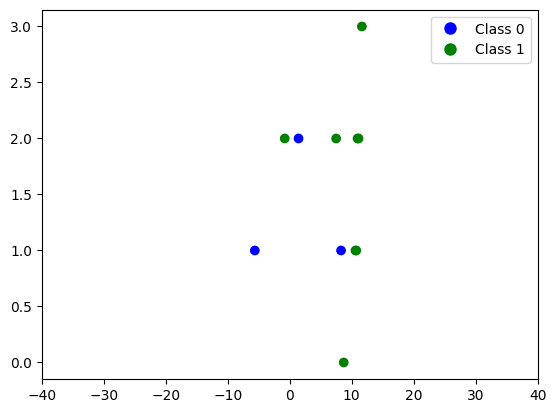

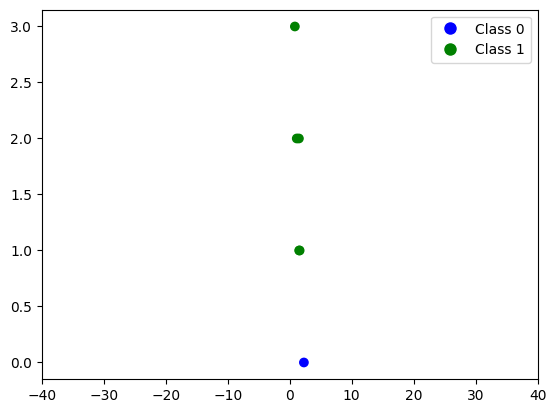

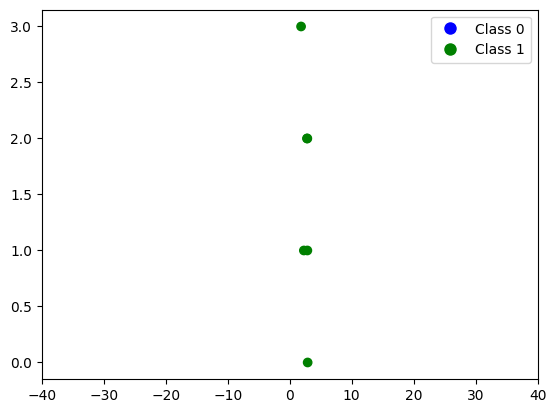

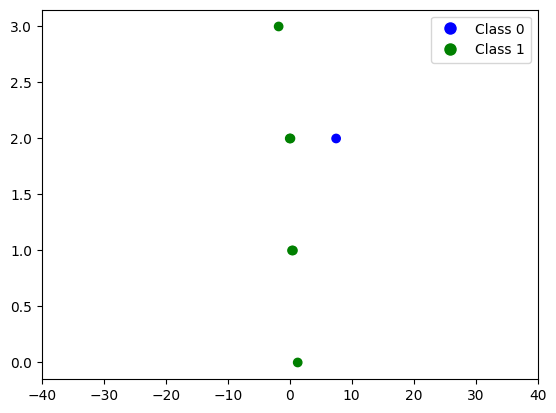

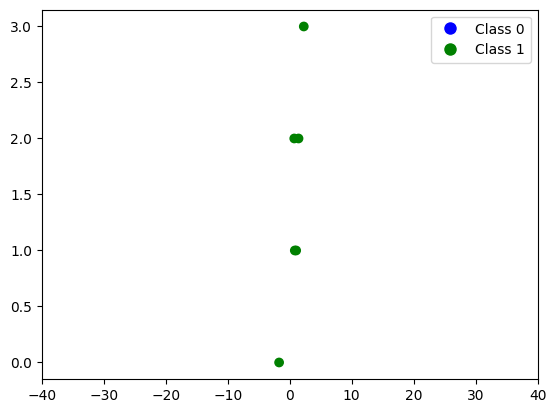

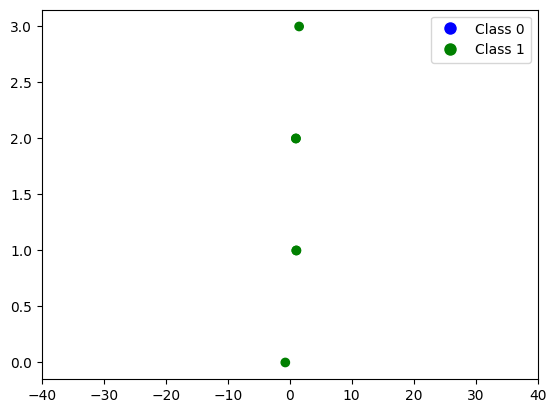

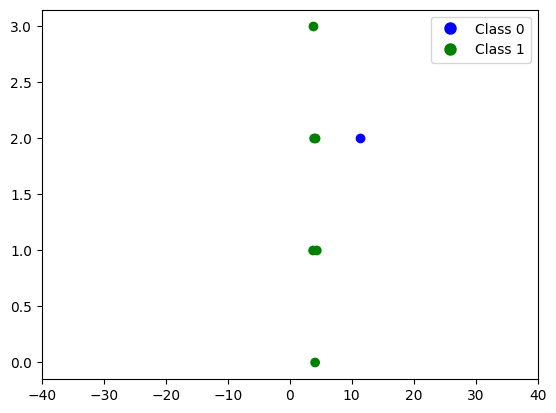

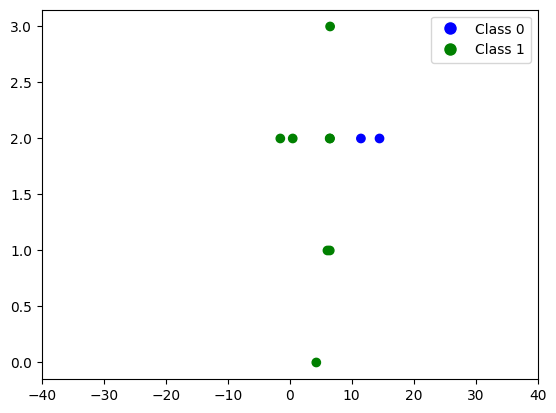

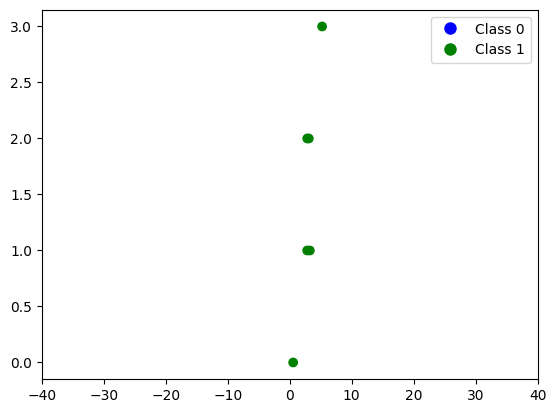

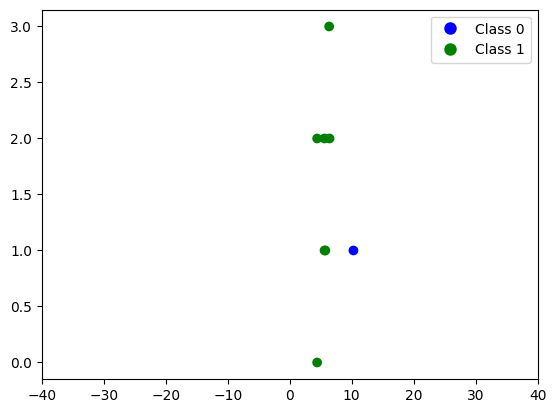

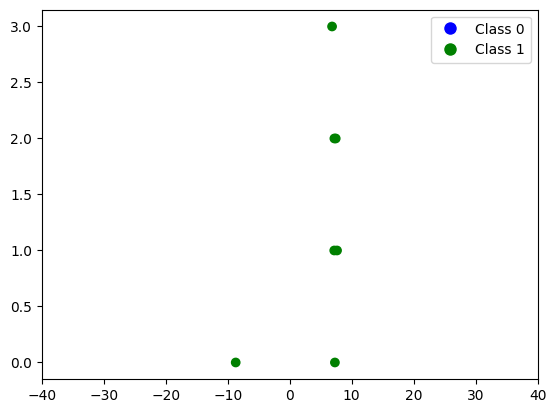

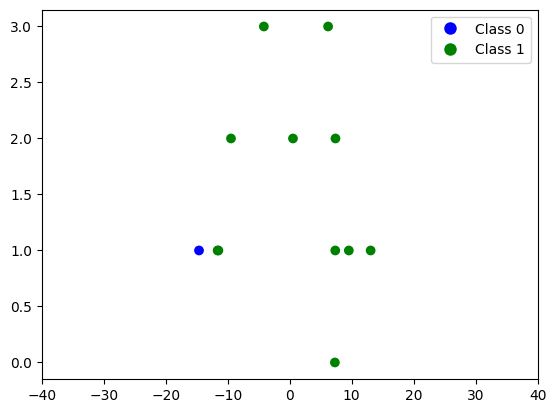

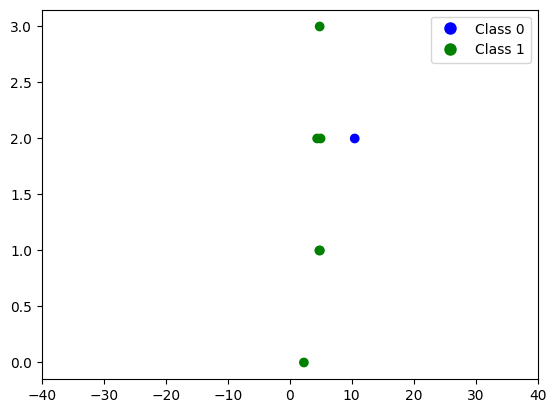

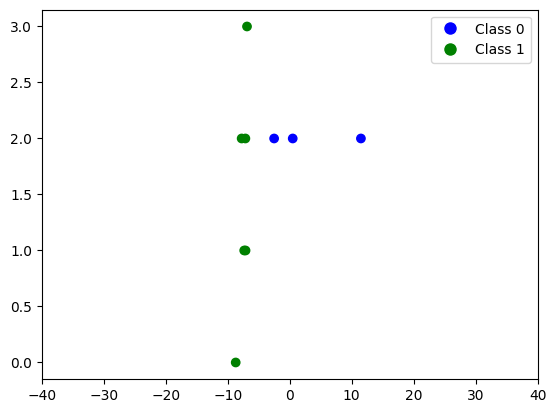

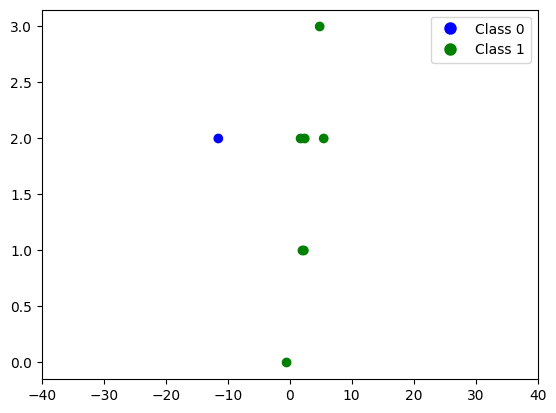

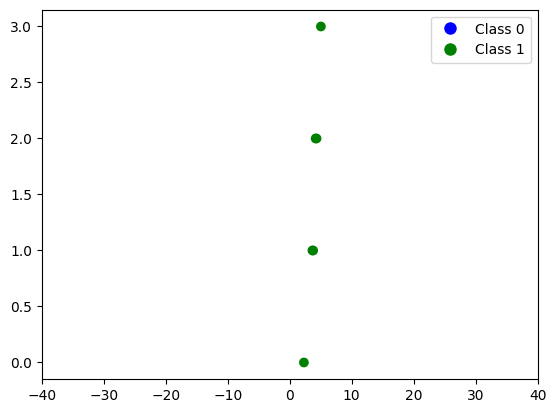

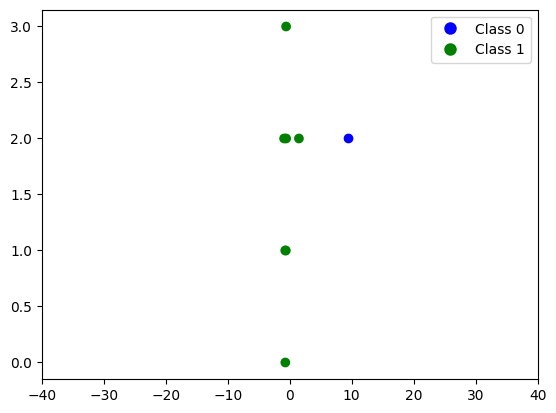

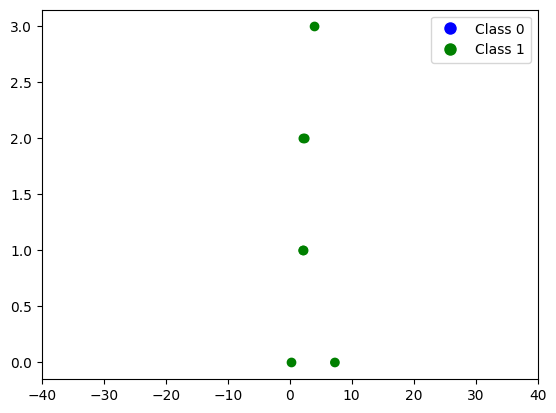

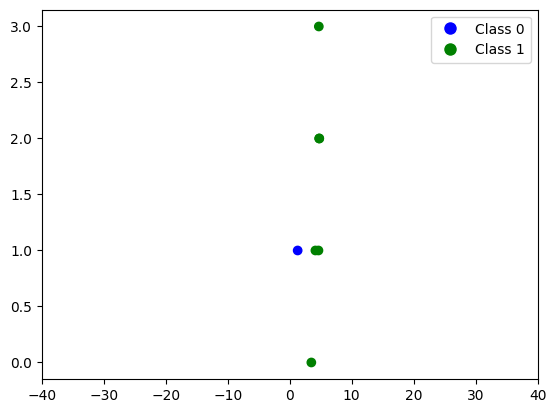

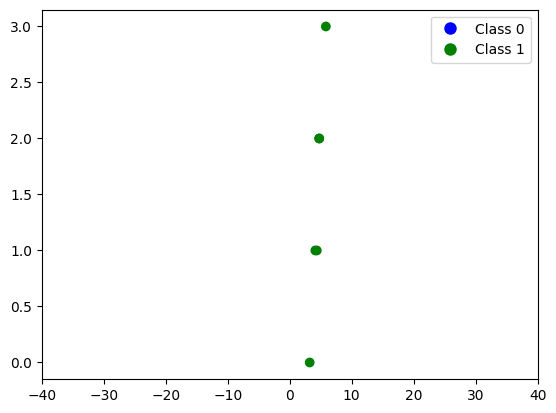

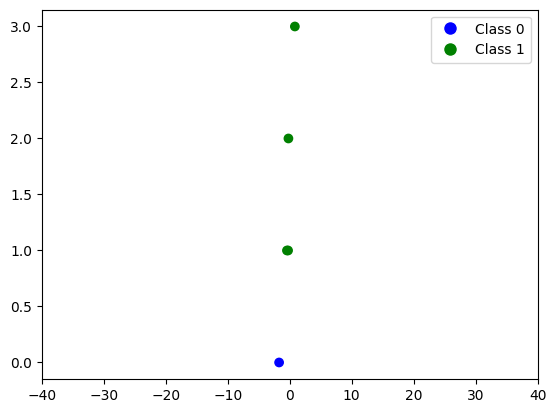

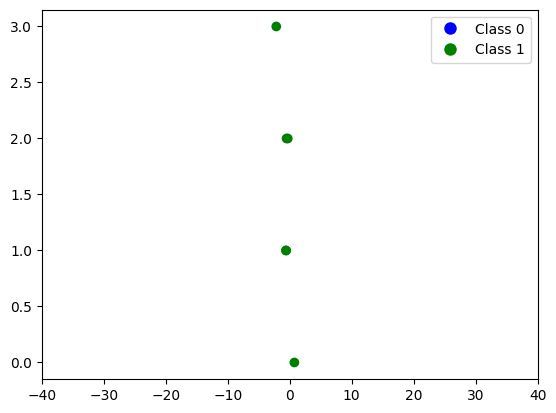

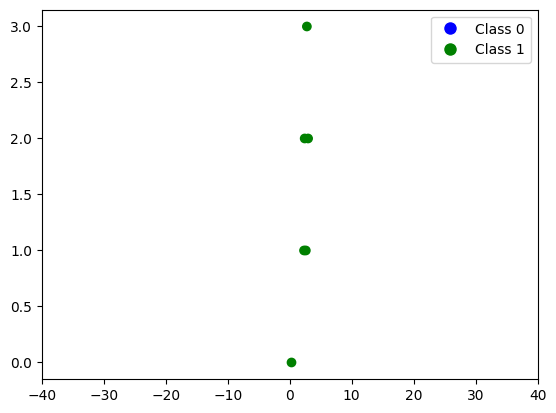

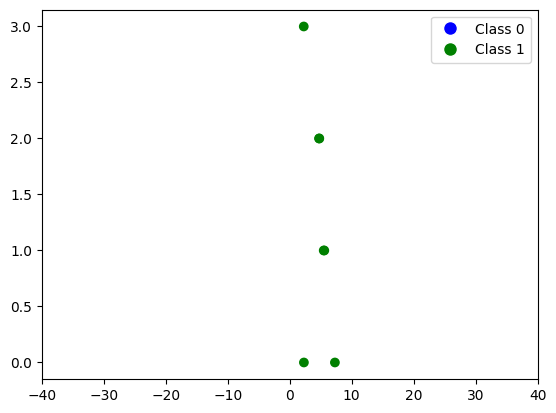

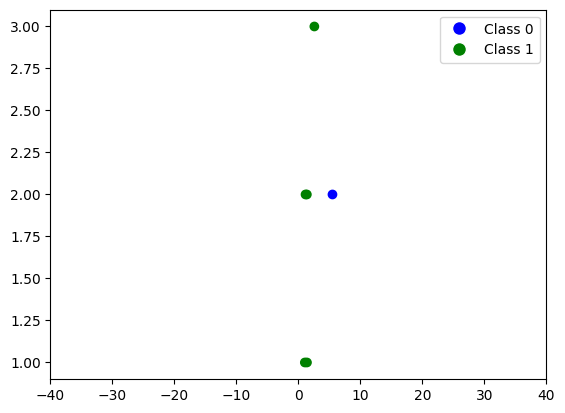

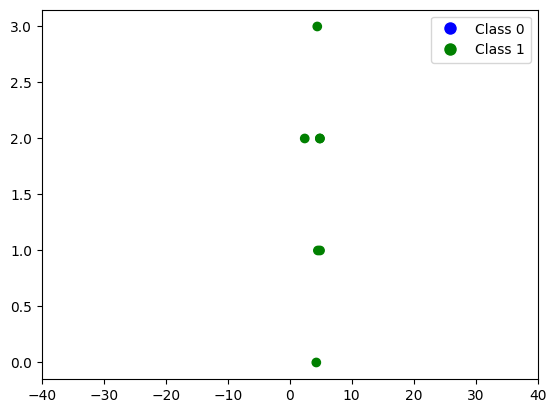

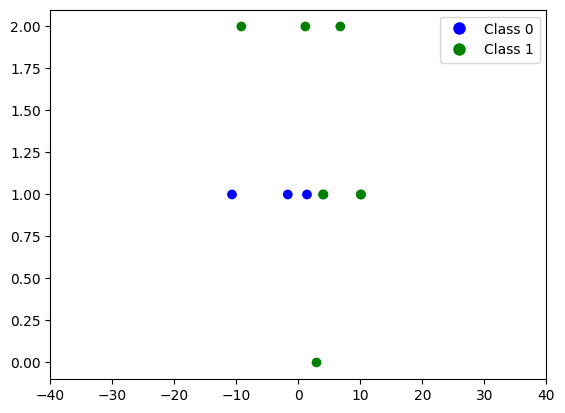

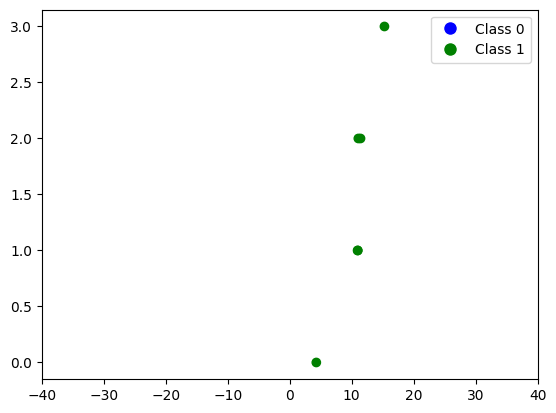

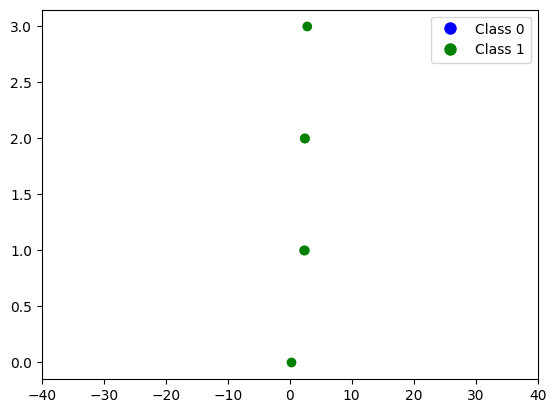

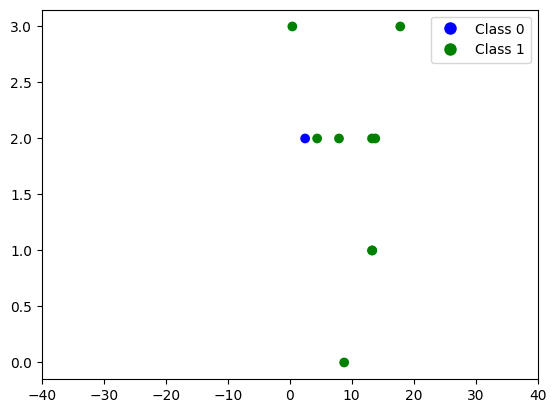

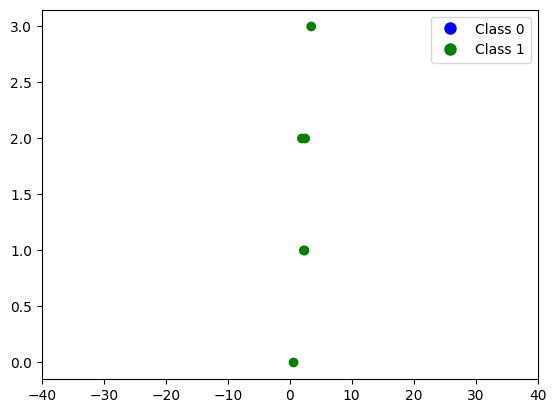

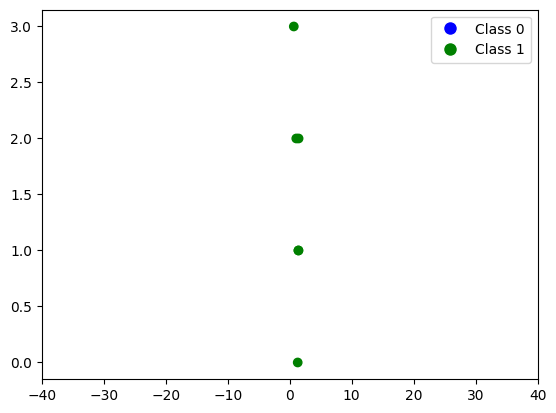

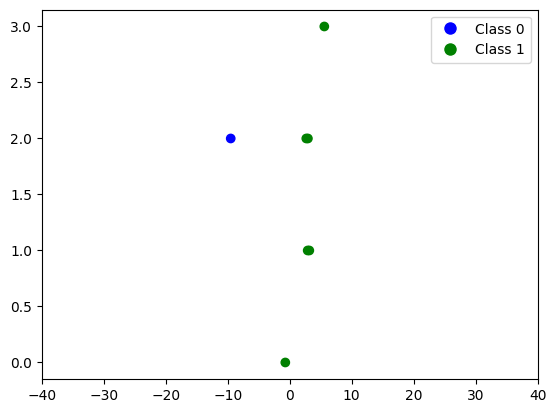

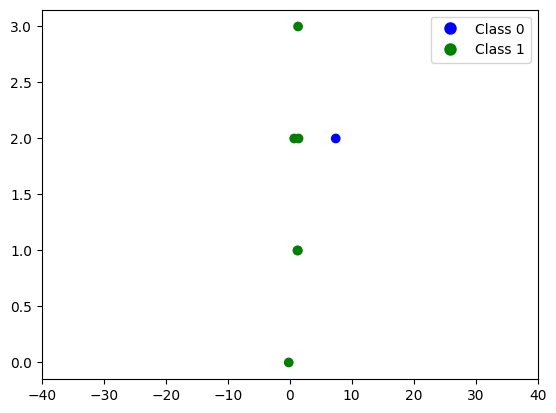

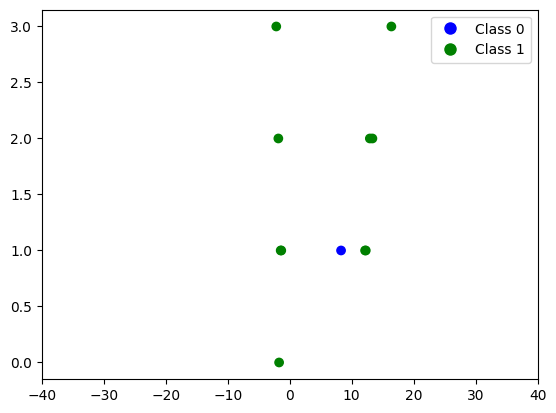

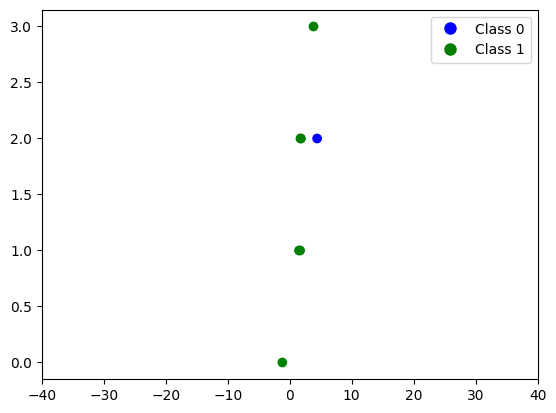

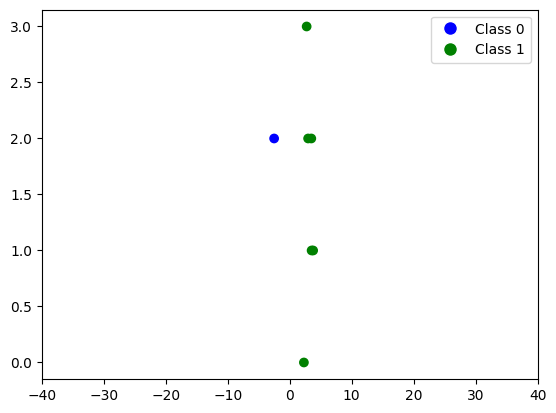

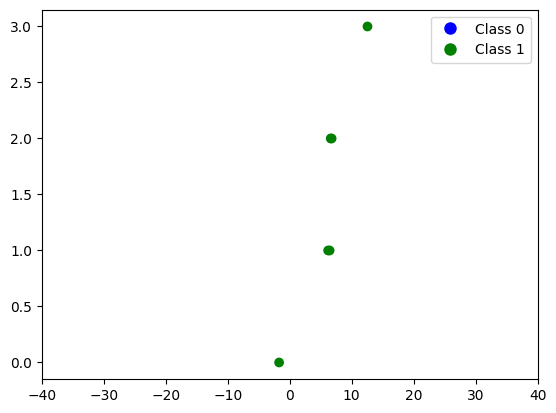

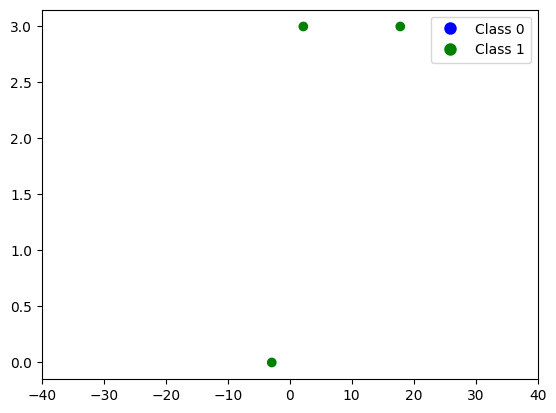

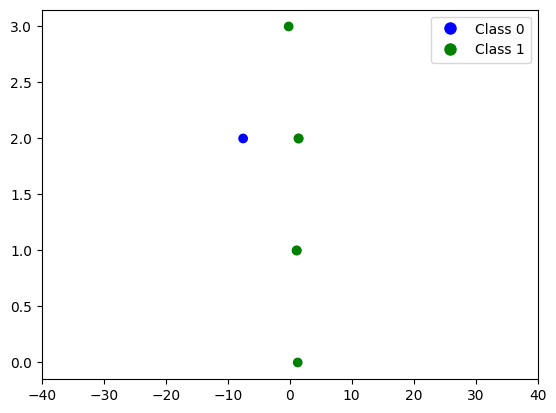

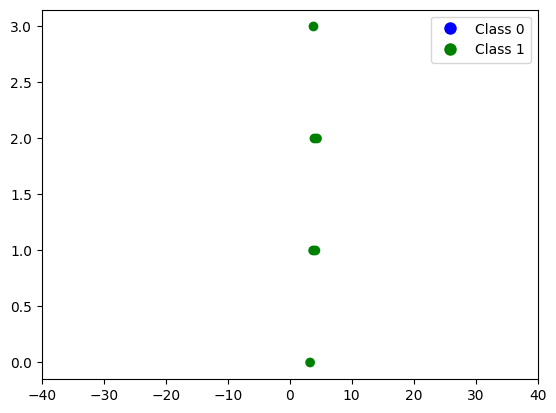

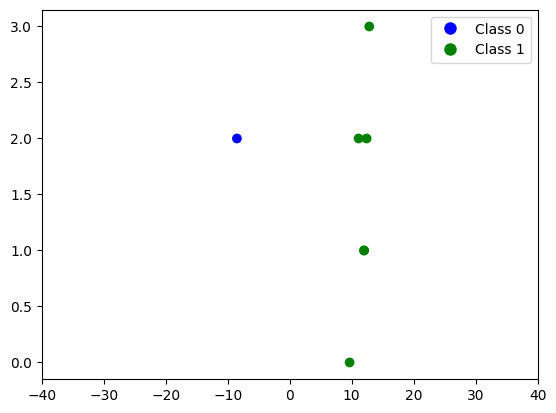

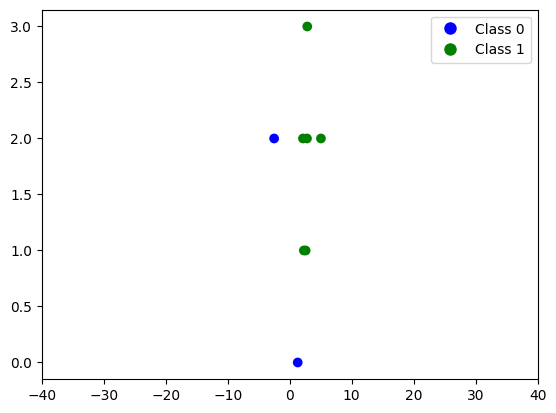

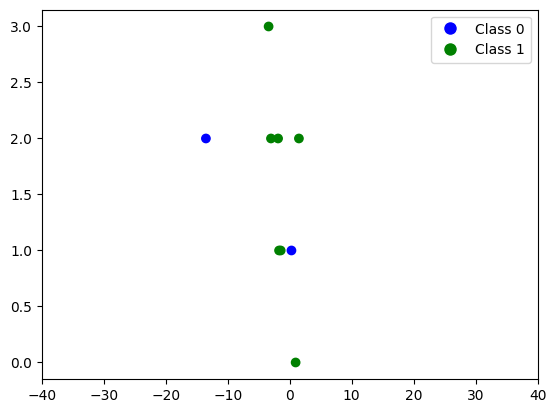

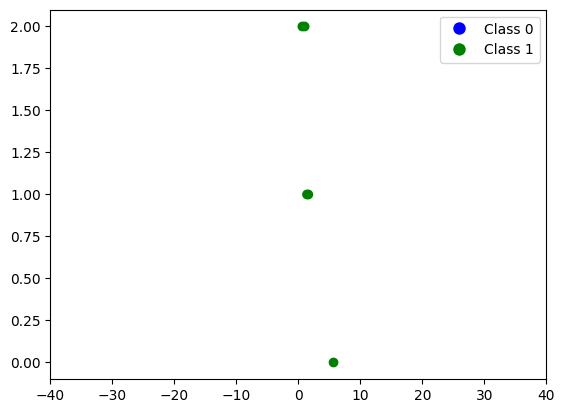

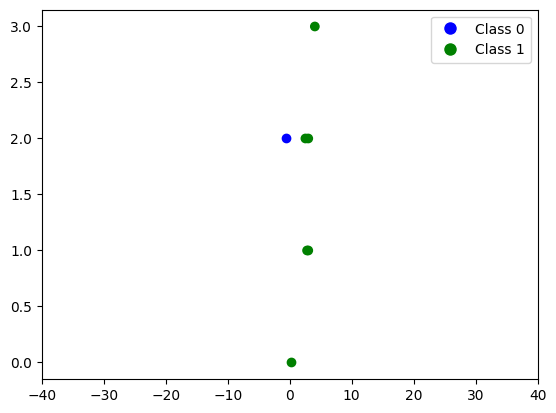

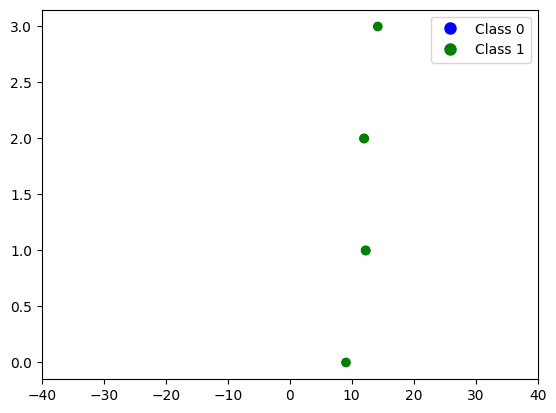

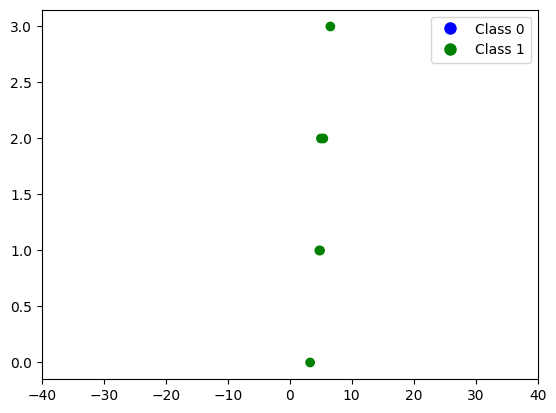

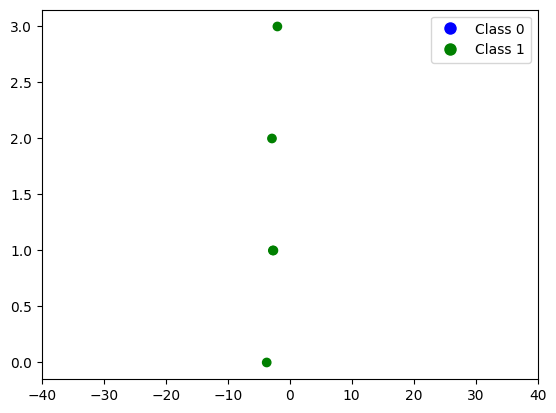

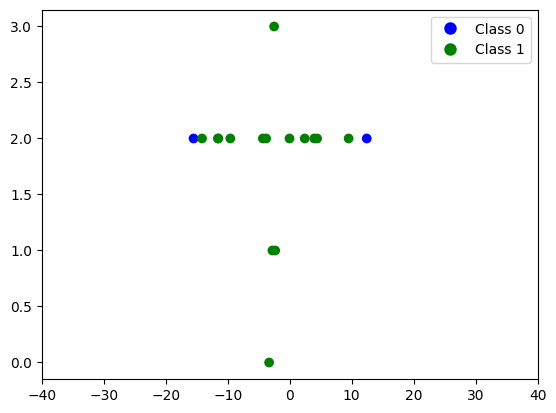

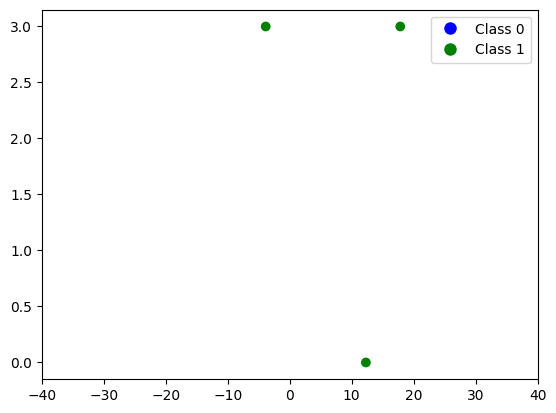

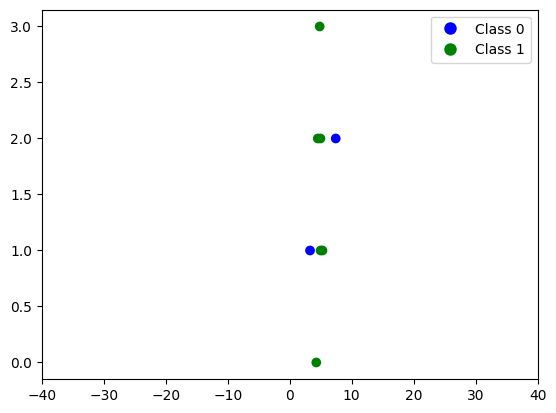

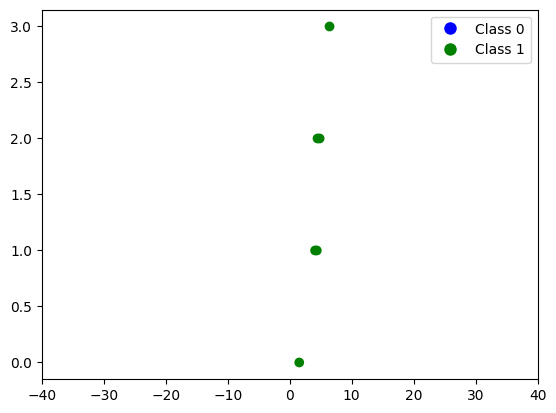

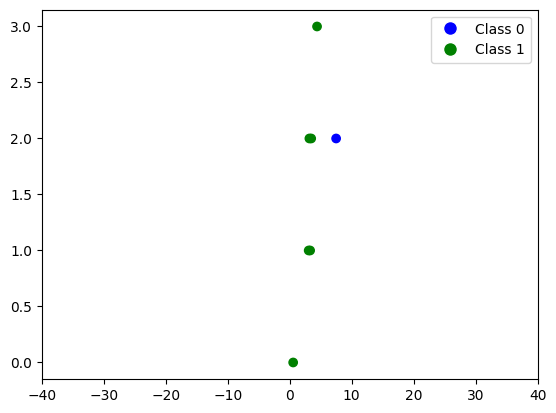

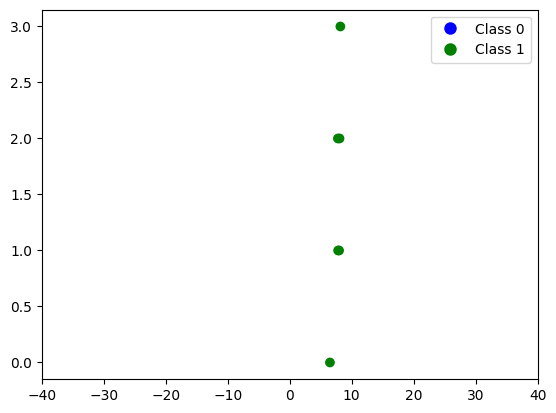

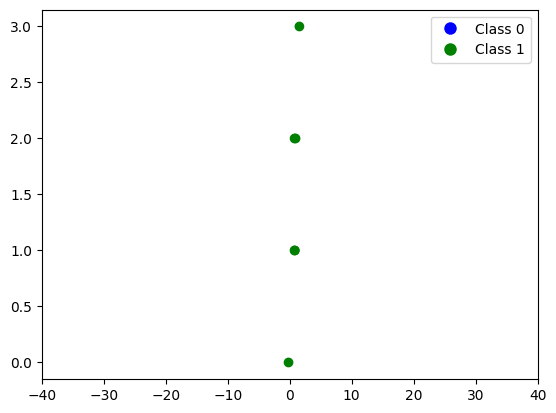

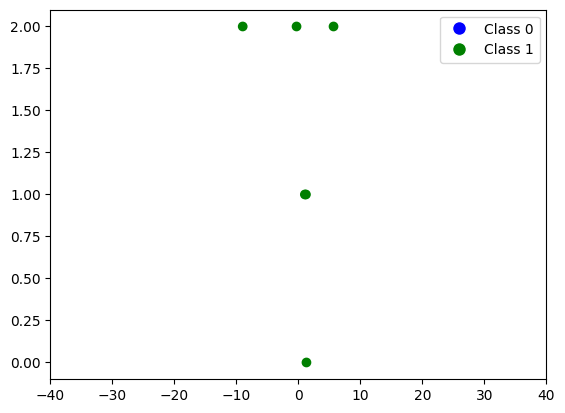

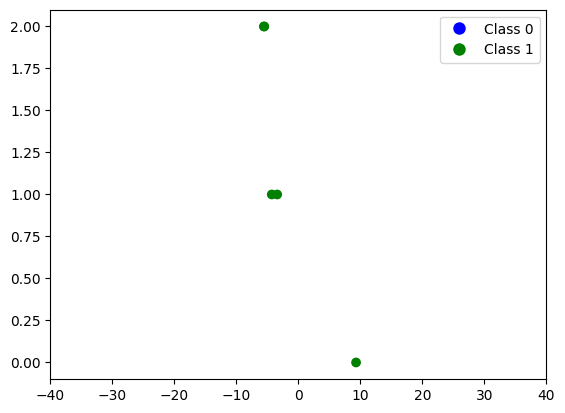

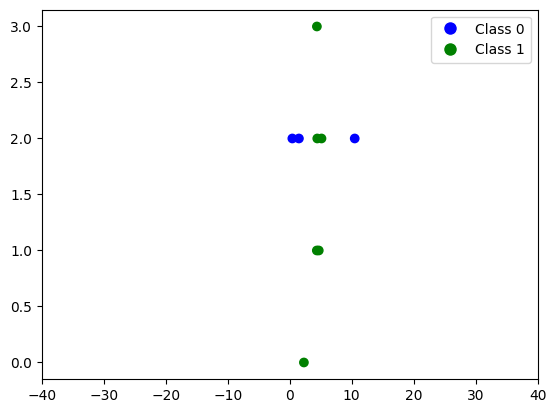

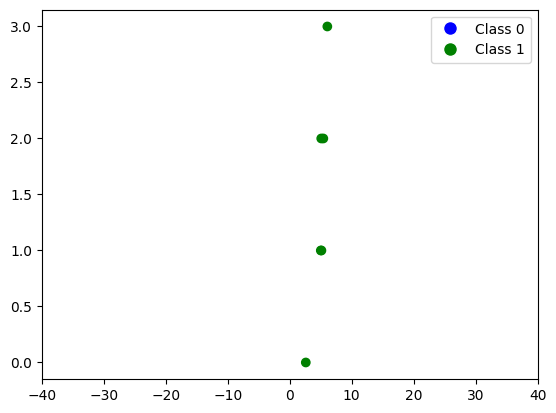

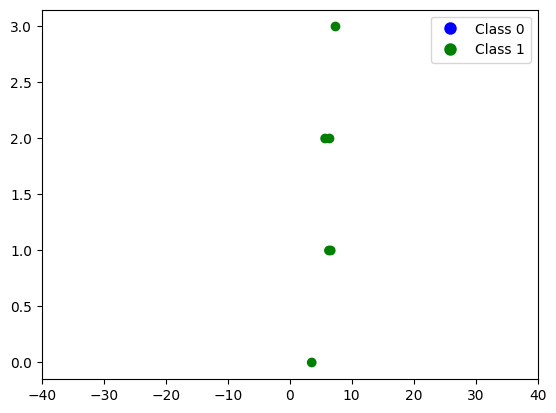

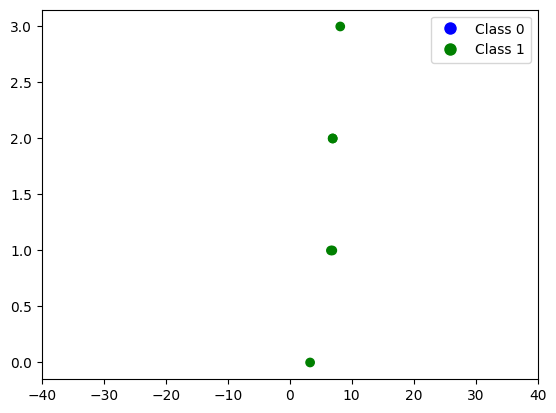

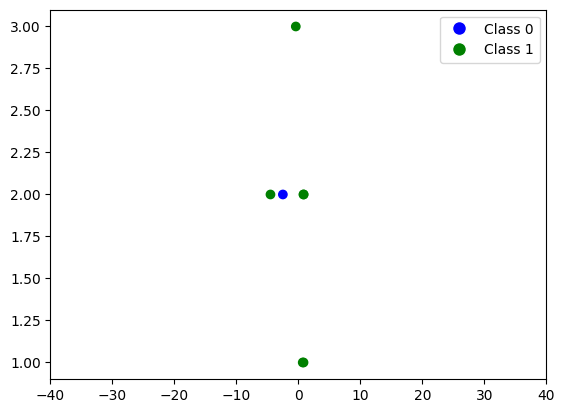

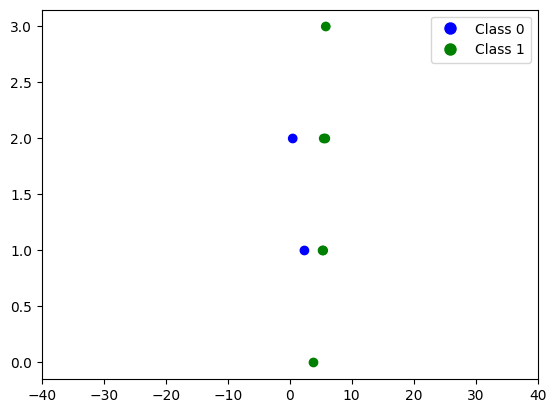

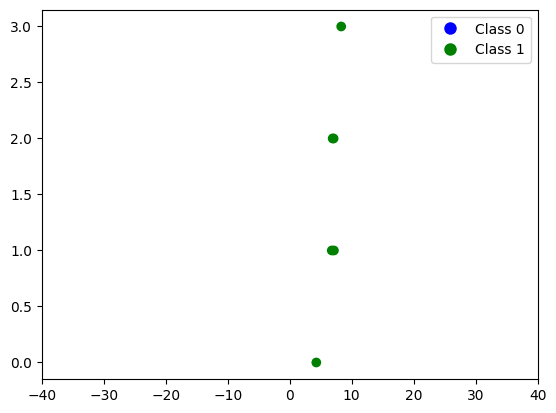

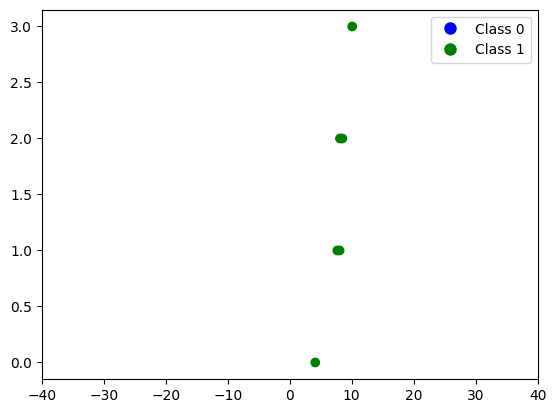

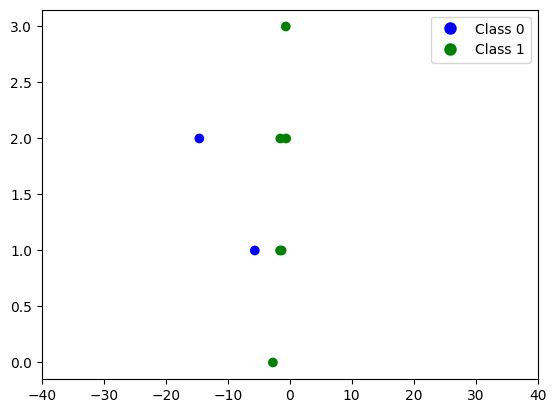

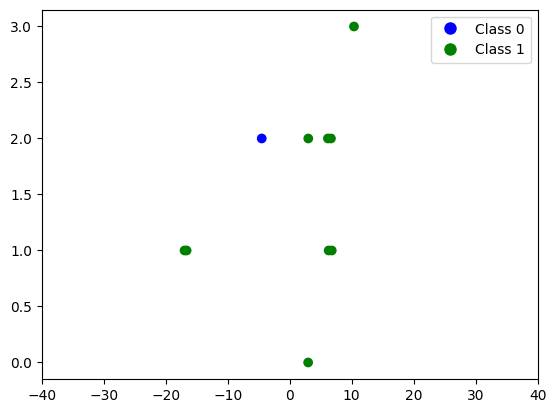

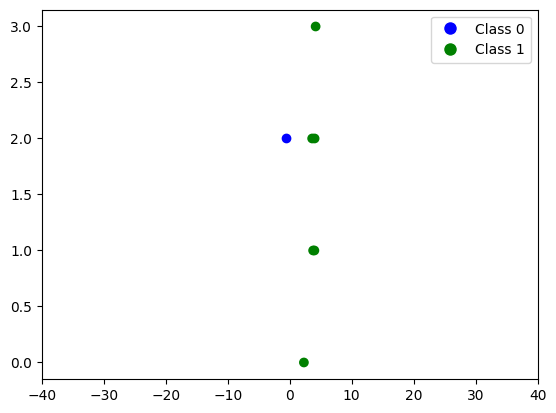

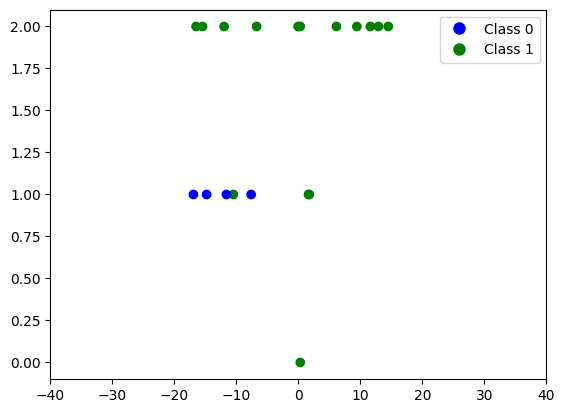

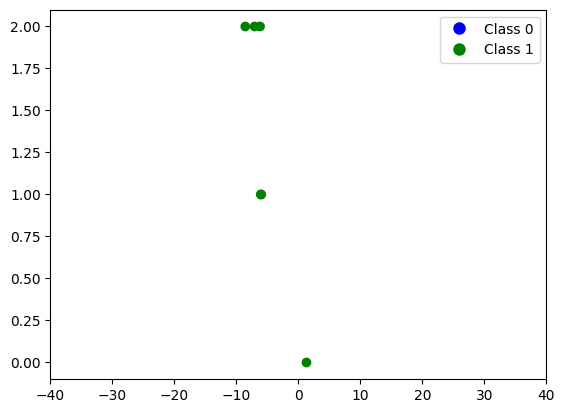

KeyboardInterrupt: 

In [108]:
for i in exp_df.Ev.unique():
    hit_class_colors = exp_df[exp_df.Ev == i].y_pred.map({0: 'blue', 1: 'green'})
    plt.scatter(exp_df[exp_df.Ev==i].x_hit,exp_df[exp_df.Ev==i].ly,c=hit_class_colors)
    
    legend_labels = {'blue': 'Class 0', 'green': 'Class 1'}
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[color], markerfacecolor=color, markersize=10) for color in ['blue', 'green']]
    plt.legend(handles=legend_handles, loc='upper right')
    plt.xlim(-40,40)
    plt.show()